In [1]:
import torch 
import torchvision

In [2]:
class pca():
    def __init__(self,n_comps):
        self.n_comps=n_comps
    def fit(self,X):
        # X is a tensor, of shape (n_samples,n_features)
        mu = torch.mean(X,dim=0)
        X=X-mu
        self.eigenvalues,self.eigenvectors=torch.linalg.eig(torch.matmul(X.t(),X))
        self.eigenvalues=self.eigenvalues.real
        self.eigenvectors=self.eigenvectors.real
        ## sort eigenvector matrix by eigenvalues
        idx = torch.argsort(self.eigenvalues,descending=True)
        self.eigenvalues=self.eigenvalues[idx]
        self.eigenvectors=self.eigenvectors[:,idx]
        self.components=self.eigenvectors[:,:self.n_comps]
    def transform(self,X):
        return torch.matmul(X,self.components)
    def fit_transform(self,X):
        self.fit(X)
        return self.transform(X)
    def inverse_transform(self,X):
        return torch.matmul(X,self.components.t())


In [7]:
from torchvision import datasets, transforms
## load mnist dataset.
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
valset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)



In [8]:
trainset.data.view(-1,28*28).shape

torch.Size([60000, 784])

In [ ]:

### training over different versions of pca, and comparing it to sklearn's pca
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import numpy as np

comps_list=[500,300,150,30]
my_pca=[]
skl_pca=[]
my_pca_val=[]
skl_pca_val=[]

for comps in comps_list:
    ##my_pca
    pca_fitter=pca(comps)
    transformed_data=pca_fitter.fit_transform(trainset.data.view(-1,28*28).float())
    
    mlp = MLPClassifier()
    mlp.fit(transformed_data,trainset.targets)
    preds=mlp.predict(transformed_data)
    acc=accuracy_score(trainset.targets,preds)
    print(f"my_pca with {comps} components, training accuracy: {acc}")
    my_pca.append(acc)
    val_transformed_data=pca_fitter.transform(valset.data.view(-1,28*28).float())
    preds=mlp.predict(val_transformed_data)
    acc=accuracy_score(valset.targets,preds)
    print(f"my_pca with {comps} components, validation accuracy: {acc}")
    my_pca_val.append(acc)
    
    ##sk_pca
    sk_pca=PCA(n_components=comps)
    transformed_data=sk_pca.fit_transform(trainset.data.view(-1,28*28).float())
    mlp = MLPClassifier()
    mlp.fit(transformed_data,trainset.targets)
    preds=mlp.predict(transformed_data)
    acc=accuracy_score(trainset.targets,preds)
    print(f"sk_pca with {comps} components, accuracy: {acc}")
    skl_pca.append(acc)
    
    val_transformed_data=sk_pca.transform(valset.data.view(-1,28*28).float())
    preds=mlp.predict(val_transformed_data)
    acc=accuracy_score(valset.targets,preds)
    print(f"sk_pca with {comps} components, validation accuracy: {acc}")
    skl_pca_val.append(acc)


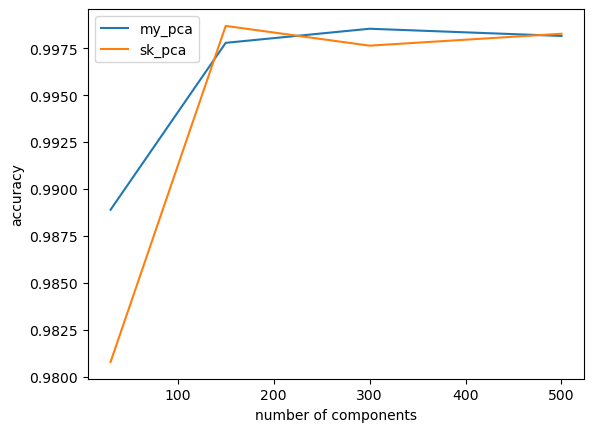

In [10]:

import matplotlib.pyplot as plt
plt.plot(comps_list,my_pca,label="my_pca")
plt.plot(comps_list,skl_pca,label="sk_pca")
plt.xlabel("number of components")
plt.ylabel("accuracy")
plt.legend()
plt.show()

    

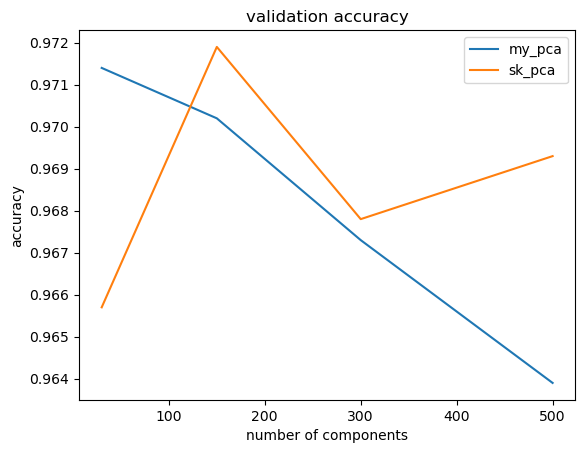

In [11]:
plt.plot(comps_list,my_pca_val,label="my_pca")
plt.plot(comps_list,skl_pca_val,label="sk_pca")
plt.xlabel("number of components")
plt.ylabel("accuracy")
plt.title("validation accuracy")
plt.legend()
plt.show()